# Predicting Hotel booking cancellations \- Group Project 2 \- Machine Learning in Python

Contributors: Sondre Wikberg (s1863042), Tomas Maksimovic (s1903823), Emily Georgiadou (s1946112), Fraser Singh  (s2268606) Group 14



## General Setup



In [26]:
#importing modules and libraries required for the report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, r2_score, classification_report,roc_curve, auc
from sklearn.base import clone
import matplotlib.ticker as ticker
import folium
import plotly.express as px

# Display plots inline
%matplotlib inline

# Plotting and Figure defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
styles = [dict(selector="caption", props=[("font-size","110%"),("font-weight", "bold")])]

#Suppress specific warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Introduction



The aim of this work was to analyse a public dataset detailing booking history from two hotels in Portugal and to ascertain the main influencing factors on booking cancellations, ultimately constructing a predictive model that would accurately \(and with confidence\) classify whether a booking is likely to be cancelled. Previewed below, the provided dataset contained 119,390 observations with the following variables describing various metrics of the bookings row by row. Bookings were made between July 1st 2015 and August 31st 2017.

NB: The data had previously been examined by the authors of the data \(Antonio, de Almeida and Nunes, Dec 2017\) and more recently by \(Chen _et al.,_  2023\) as part of a larger analysis to improve the use of Passenger Name Records \(PNR\) in similar classification predictions.

The dataset contains information on the booking's start and end date, whether it was booked through a third party, details of the guests \(number of adults, children, and babies\), guest country of origin, the average price paid per night, what type of catering the guest booked \(if any\), the type of rooms they booked and that which they were assigned. The "<span style='font-family:Courier'>hotel</span>" feature indicates whether the corresponding entry was for a "Resort Hotel" or a "City Hotel", column "<span style='font-family:Courier'>is\_repeated_guest</span>" indicates if a guest has stayed at the hotel before, whereas "<span style='font-family:Courier'>previous_cancellations</span>" and "<span style='font-family:Courier'>previous\_bookings\_not\_cancelled</span>" indicate whether the guest has previously stayed or booked and then cancelled, respectively. Column "<span style='font-family:Courier'>adr</span>" indicates the average daily rate quoted for the booking.

After conducting extensive data cleaning, feature engineering, and subsequent extraction, we fit a decision tree classifier, a support vector classifier, a random forest, and a logistic regression model to the data. The hyperparameters of all models were optimised by means of several five\-fold cross validations. Based on the results for the feature\-engineered data, we propose a logistic regression model for the client as a means of predicting whether a booking will be cancelled. While accuracy for the random forest was marginally better than the logistic regression, we chose the latter as our model of choice due its superior interpretability and comparatively lighter computational resource demand, which will be relevant if the hotel owner\(s\) wish to refit the model given more data in the future.

The model revealed that bookings requiring a car park \(<span style='font-family:Courier'>Requiring\_car\_park</span>\) were least likely to be cancelled, whilst those where the cost of the stay was paid in full at the time of booking \(<span style='font-family:Courier'>deposit\_type\_No\_refund</span>\) were the most likely to be cancelled. We recommend reading the discussion for more indicators of cancellation likelihood and for further elaboration on the inaccuracies in the data which we could not rectify, and subsequent recommendations we make for future data collection to improve the data available to re\-train this model in future analyses.


In [27]:
# Load data
d = pd.read_csv("hotel.csv")

In [28]:
#Show data preview
display(d.iloc[:, 0:8].head(2).style.set_caption('Original data').set_table_styles(styles))
display(d.iloc[:, 8:18].head(2).style.set_caption('Original data').set_table_styles(styles))
display(d.iloc[:, 18:26].head(2).style.set_caption('Original data').set_table_styles(styles))
display(d.iloc[:, 26:].head(2).style.set_caption('Original data').set_table_styles(styles))

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights
0,0,Resort Hotel,342,2015,July,27,1,0
1,0,Resort Hotel,737,2015,July,27,1,0


,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations
0,0,2,0.000000,0,BB,PRT,Direct,Direct,0,0
1,0,2,0.000000,0,BB,PRT,Direct,Direct,0,0


,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list
0,0,C,C,3,No Deposit,nan,nan,0
1,0,C,C,4,No Deposit,nan,nan,0


,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Transient,0.000000,0,0
1,Transient,0.000000,0,0


For the variables "meal", "market_segment", "distribution_channel", "deposit_type", and "customer type", we inspect the categories present in the data.

In [5]:
for col in ["meal", "market_segment", "distribution_channel", "deposit_type", "customer_type"]:
    print(col+":", d[col].unique())

meal: ['BB' 'FB' 'HB' 'SC' 'Undefined']
market_segment: ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']
distribution_channel: ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']
deposit_type: ['No Deposit' 'Refundable' 'Non Refund']
customer_type: ['Transient' 'Contract' 'Transient-Party' 'Group']


Under "market_segment" and "distribution_channel", we note that categories "TA" and "TO" indicate whether the booking was made through a travel agent/operator and "GDS" indicates a pooled hotel browsing system for travel agents. The categories under "meal" indicate whether the guest booked full board ("FB"), half-board ("HB"), only breakfast ("BB"), self-catered ("SC"), or whether the option was undefined. Under "customer_type", category "Transient" indicates that the booking is not part of a group or contract, and is not associated with any other such booking. Meanwhile, "Transient-Party" indicates that the booking was not made through a group or contract, but is associated with at least one other transient booking.



## Exploratory Data Analysis \(EDA\) and Feature Engineering



### Data Cleaning 

First, we were interested in whether there were any duplicates in the data.  From the cell below, we noted that there were 32,252 duplicated values in the dataset. Whilst identical observations could theoretically correspond to a single booking \(and so would be duplicates warranting deletion\), we chose to keep those entries, hypothesising that separate families or groups could have coordinated their holidays and made corresponding bookings.


In [6]:
#checking how many duplicates there are
print("Number of duplicates: ", d[d.duplicated()].shape[0])

Number of duplicates:  32252


We then assessed the extent of missing data. Below, are counts of the missing entries, grouped by their feature of origin.


In [7]:
#print number of missing entries in each column
for col in d.columns:
    if np.sum(d[col].isna()) != 0:
        print(col + ": ", np.sum(d[col].isna()))

#print number of unique entries in agent and company variables
print("Number of unique entries under 'agent': ", d["agent"].nunique())
print("Number of unique entries under 'company': ", d["company"].nunique())

children:  4
country:  488
agent:  16340
company:  112593
Number of unique entries under 'agent':  333
Number of unique entries under 'company':  352


We noted that, compared to the size of the dataset, there were extremely few missing values in the "<span style='font-family:Courier'>children</span>" and "<span style='font-family:Courier'>country</span>" columns \(&lt;0.5%\). In order to homogenise our data, we thus deleted any entries for which these observations were missing and accepted the loss of data. For column "<span style='font-family:Courier'>agent</span>", about 14% of entries were missing . This was a relatively large proportion, and we were unable to make assumptions about the nature of such a gap. In other words, we could not justify the omission of bookings based on missing <span style='font-family:Courier'>agent </span>data. As a result of this, and due to difficulties  in high dimensionality arising from encoding so many agents \(333\), we decided to delete this column. Similarly, for the feature "<span style='font-family:Courier'>company</span>", about 94% of values were missing. Again, we could not make assumptions about the "<span style='font-family:Courier'>company</span>" ID's in these entries, and so we chose to also remove this column.


In [8]:
#Drop entries for which "children" or "country data is missing"
d.dropna(subset=['children', "country"], inplace=True)

#Drop columns 'agent' and 'company'"
d = d.drop(["agent", "company"], axis=1)
print('Dropped "agent" and "company"')

Dropped "agent" and "company"


### Outliers

As part of our data analysis, we checked for outliers in our numerical variables. Outliers are observations that stray far from the normal range of values and can skew our findings and results. By identifying and removing the outliers, we can ensure that our data is more representative and our analysis is more reliable. We decided to delete the 99th percentile of entries for the majority of numerical entries that were not binary. The 99th percentile of entries were kept for some categorical variables for which it made sense to encode entries in a binary manner. Our analysis of outliers, and the subsequent deletion of some entries, is outlined below. 


In [9]:
#create copy of data in order to properly delete entries above 99th percentile
df = d.copy()

# We will split our data in numerical columns
num_cols = df.select_dtypes(include='number')

# Name the columns, which we will use later
num_cols_names = num_cols.columns

#Get summary statistics of each variable/column
summary = num_cols.describe(percentiles = [0.01, 0.05, 0.95, 0.99])
display(summary)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000
mean,0.371352,104.311435,2016.157656,27.166555,15.800880,0.928897,2.502145,1.858391,0.104207,0.007948,0.032011,0.087142,0.131634,0.221181,2.330754,102.003243,0.061885,0.571683
std,0.483168,106.903309,0.707459,13.589971,8.780324,0.996216,1.900168,0.578576,0.399172,0.097380,0.176029,0.845869,1.484672,0.652785,17.630452,50.485862,0.244172,0.792678
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
1%,0.000000,0.000000,2015.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,2015.000000,5.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000
95%,1.000000,320.000000,2017.000000,49.000000,30.000000,2.000000,5.000000,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,193.500000,1.000000,2.000000
99%,1.000000,444.000000,2017.000000,53.000000,31.000000,4.000000,10.000000,3.000000,2.000000,0.000000,1.000000,1.000000,3.000000,3.000000,75.000000,252.000000,1.000000,3.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


From the summary statistics above, truncated in the table below, we note that some features possess substantial differences between the 99th percentile and the maximum values, indicating that the maximum values be removed. Entries in the 99th percentile of all numerical variables but "babies", "is_canceled", and "is_repeated_guest" were removed in the cell below. The 99th percentiles for variables "is_canceled" and "is_repeated_guest" were retained as these variables were binary. Meanwhile, no entries in column "babies" were deleted, as this would cause all non-zero entries to vanish (see table below). We thus decided to encode "babies"as a binary variable at a later stage (1 for at least one baby, 0 otherwise).

| Variable | 99th Percentile | Max | % Difference | Action |
| -------- | --------------- | --- | ----------- | ------ |
| lead_time | 444             | 737 | 66.95%      | Remove |
| stays_in_weekend_nights | 4 | 16 | 75.00%   | Remove |
| stays_in_week_nights | 10   | 41  | 75.61%   | Remove |
| adults | 3                 | 55  | 94.55%   | Remove |
| children | 2               | 10  | 80.00%   | Remove |
| babies | 0                 | 10  | N/A      | Keep   |
| is_repeated_guest | 1      | 1   | N/A      | Keep   |
| previous_cancellations | 1 | 26  | 96.15%   | Remove |
| previous_bookings_not_canceled | 3 | 72 | 95.83% | Remove |
| booking_changes | 3        | 21  | 85.71%   | Remove |
| days_in_waiting_list | 75   | 391 | 80.76%   | Remove |
| adr | 199.0              | 5400.0 | 96.31% | Remove |
| required_car_parking_spaces | 1 | 8  | 87.50% | Remove |
| is_canceled | 1           | 1   | N/A      | Keep   |

After examining the 99th percentile, we proceeded to analyse the 1st percentile. Upon review, we did not observe anything unusual except for the Average Daily Rate \(ADR\), where the minimum value was \-6.380000 and the 1st percentile was 0. This indicates that there may be a negative value for ADR, which is not possible, and hence, this error required correction. We deleted entries below the 1st percentile in the "adr" column. Changes mentioned here were effectuated in the two cells below (note that we leave encoding of the "babies" variable to the "Encoding Categorical Variables"-section)



In [12]:
# Grouping the numerical variables that will change, where we will drop entries in the 99th and/or 1st percentile
num_cols_names_change = num_cols.drop(["babies", 'is_repeated_guest', 'is_canceled'], axis=1)
ncncc = num_cols_names_change.columns
print('Removed "babies",is_repeated_guest" and "is_canceled" from columns that are to be altered')

Removed "babies",is_repeated_guest" and "is_canceled" from columns that are to be altered


In [13]:
# Define a function to drop entries above the 99th percentile for a given variable
def drop_99th_p(dataframe, variable):
    # calculate the 99th percentile
    q99 = df[variable].quantile(0.99)
    # drop entries above the 99th percentile
    dataframe2 = dataframe[dataframe[variable] <= q99]
    return dataframe2

# Apply the drop_99th_p function to all numerical rows
for col in ncncc:
    d = drop_99th_p(d, col)

# Now drop the values below the 1th percentile of adr (no need to do a function as this is for one variale only)
d = d[d['adr'] >= d['adr'].quantile(0.01)]
# Check
print(f"Dropped outlier data.\nRemaining number of entries:  {d.shape[0]}")

Dropped outlier data.
Remaining number of entries:  112609


### Imbalanced data
The chart below shows that the data which has been processed up to this point is imbalanced with regards to the response is\_canceled. We can see that 63.1% of the bookings were not cancelled whereas 36.9% were. In other words, we do not have balanced data in the response variable "is_canceled". Though this is not pertinent to our feature selection, the model building and evaluation stages of this report include parameters to stratify the model training by the response variable so that this imbalance does not cause bias in our results.

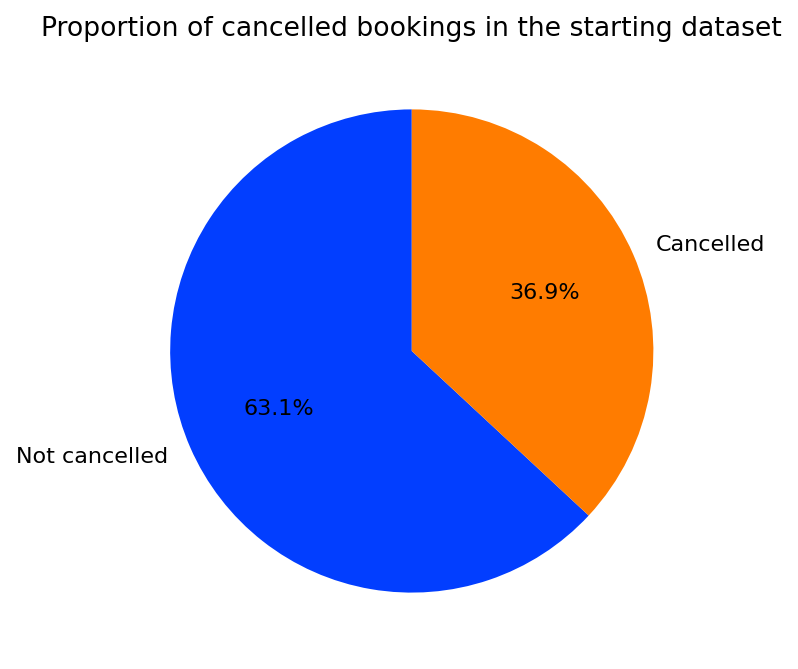

In [14]:
#Showing the imbalance in the dataset's repsonse variable
cancelled_data=d["is_canceled"].value_counts()
palette_color = sns.color_palette('bright')
cancelled_data.plot.pie(autopct='%1.1f%%', startangle=90,colors=palette_color, labels=['Not cancelled','Cancelled'],)
plt.title('Proportion of cancelled bookings in the starting dataset'); plt.axis('off'); plt.show()

### Encoding categorical variables
We note that it will be necessary to either drop or encode categorical variables as numerical ones before fitting any model. Furthermore, there are some discrete numerical variables (such as "children", "babies", "previous_cancellations", "previous_bookings_not_cancelled", "booking_changes", "required_car_parking_spaces", and "total_of_special_requests") for which we are interested in investigating the frequency. Below, we count the frequency of cancelled and non-cancelled entries of each category/value in these variables. 

Percentage of entries for variable ' children ' above 1:  2.82
Percentage of entries for variable ' babies ' above 1:  0.01
Percentage of entries for variable ' previous_cancellations ' above 1:  0.0
Percentage of entries for variable ' previous_bookings_not_canceled ' above 1:  0.7
Percentage of entries for variable ' booking_changes ' above 1:  3.95
Percentage of entries for variable ' required_car_parking_spaces ' above 1:  0.0
Percentage of entries for variable ' total_of_special_requests ' above 1:  13.05
Percentage of entries for variable ' adults ' above 1:  80.87
Percentage of entries for variable ' days_in_waiting_list ' above 1:  2.19
Percentage of entries for variable 'total_of_special_requests' above 2:  2.06


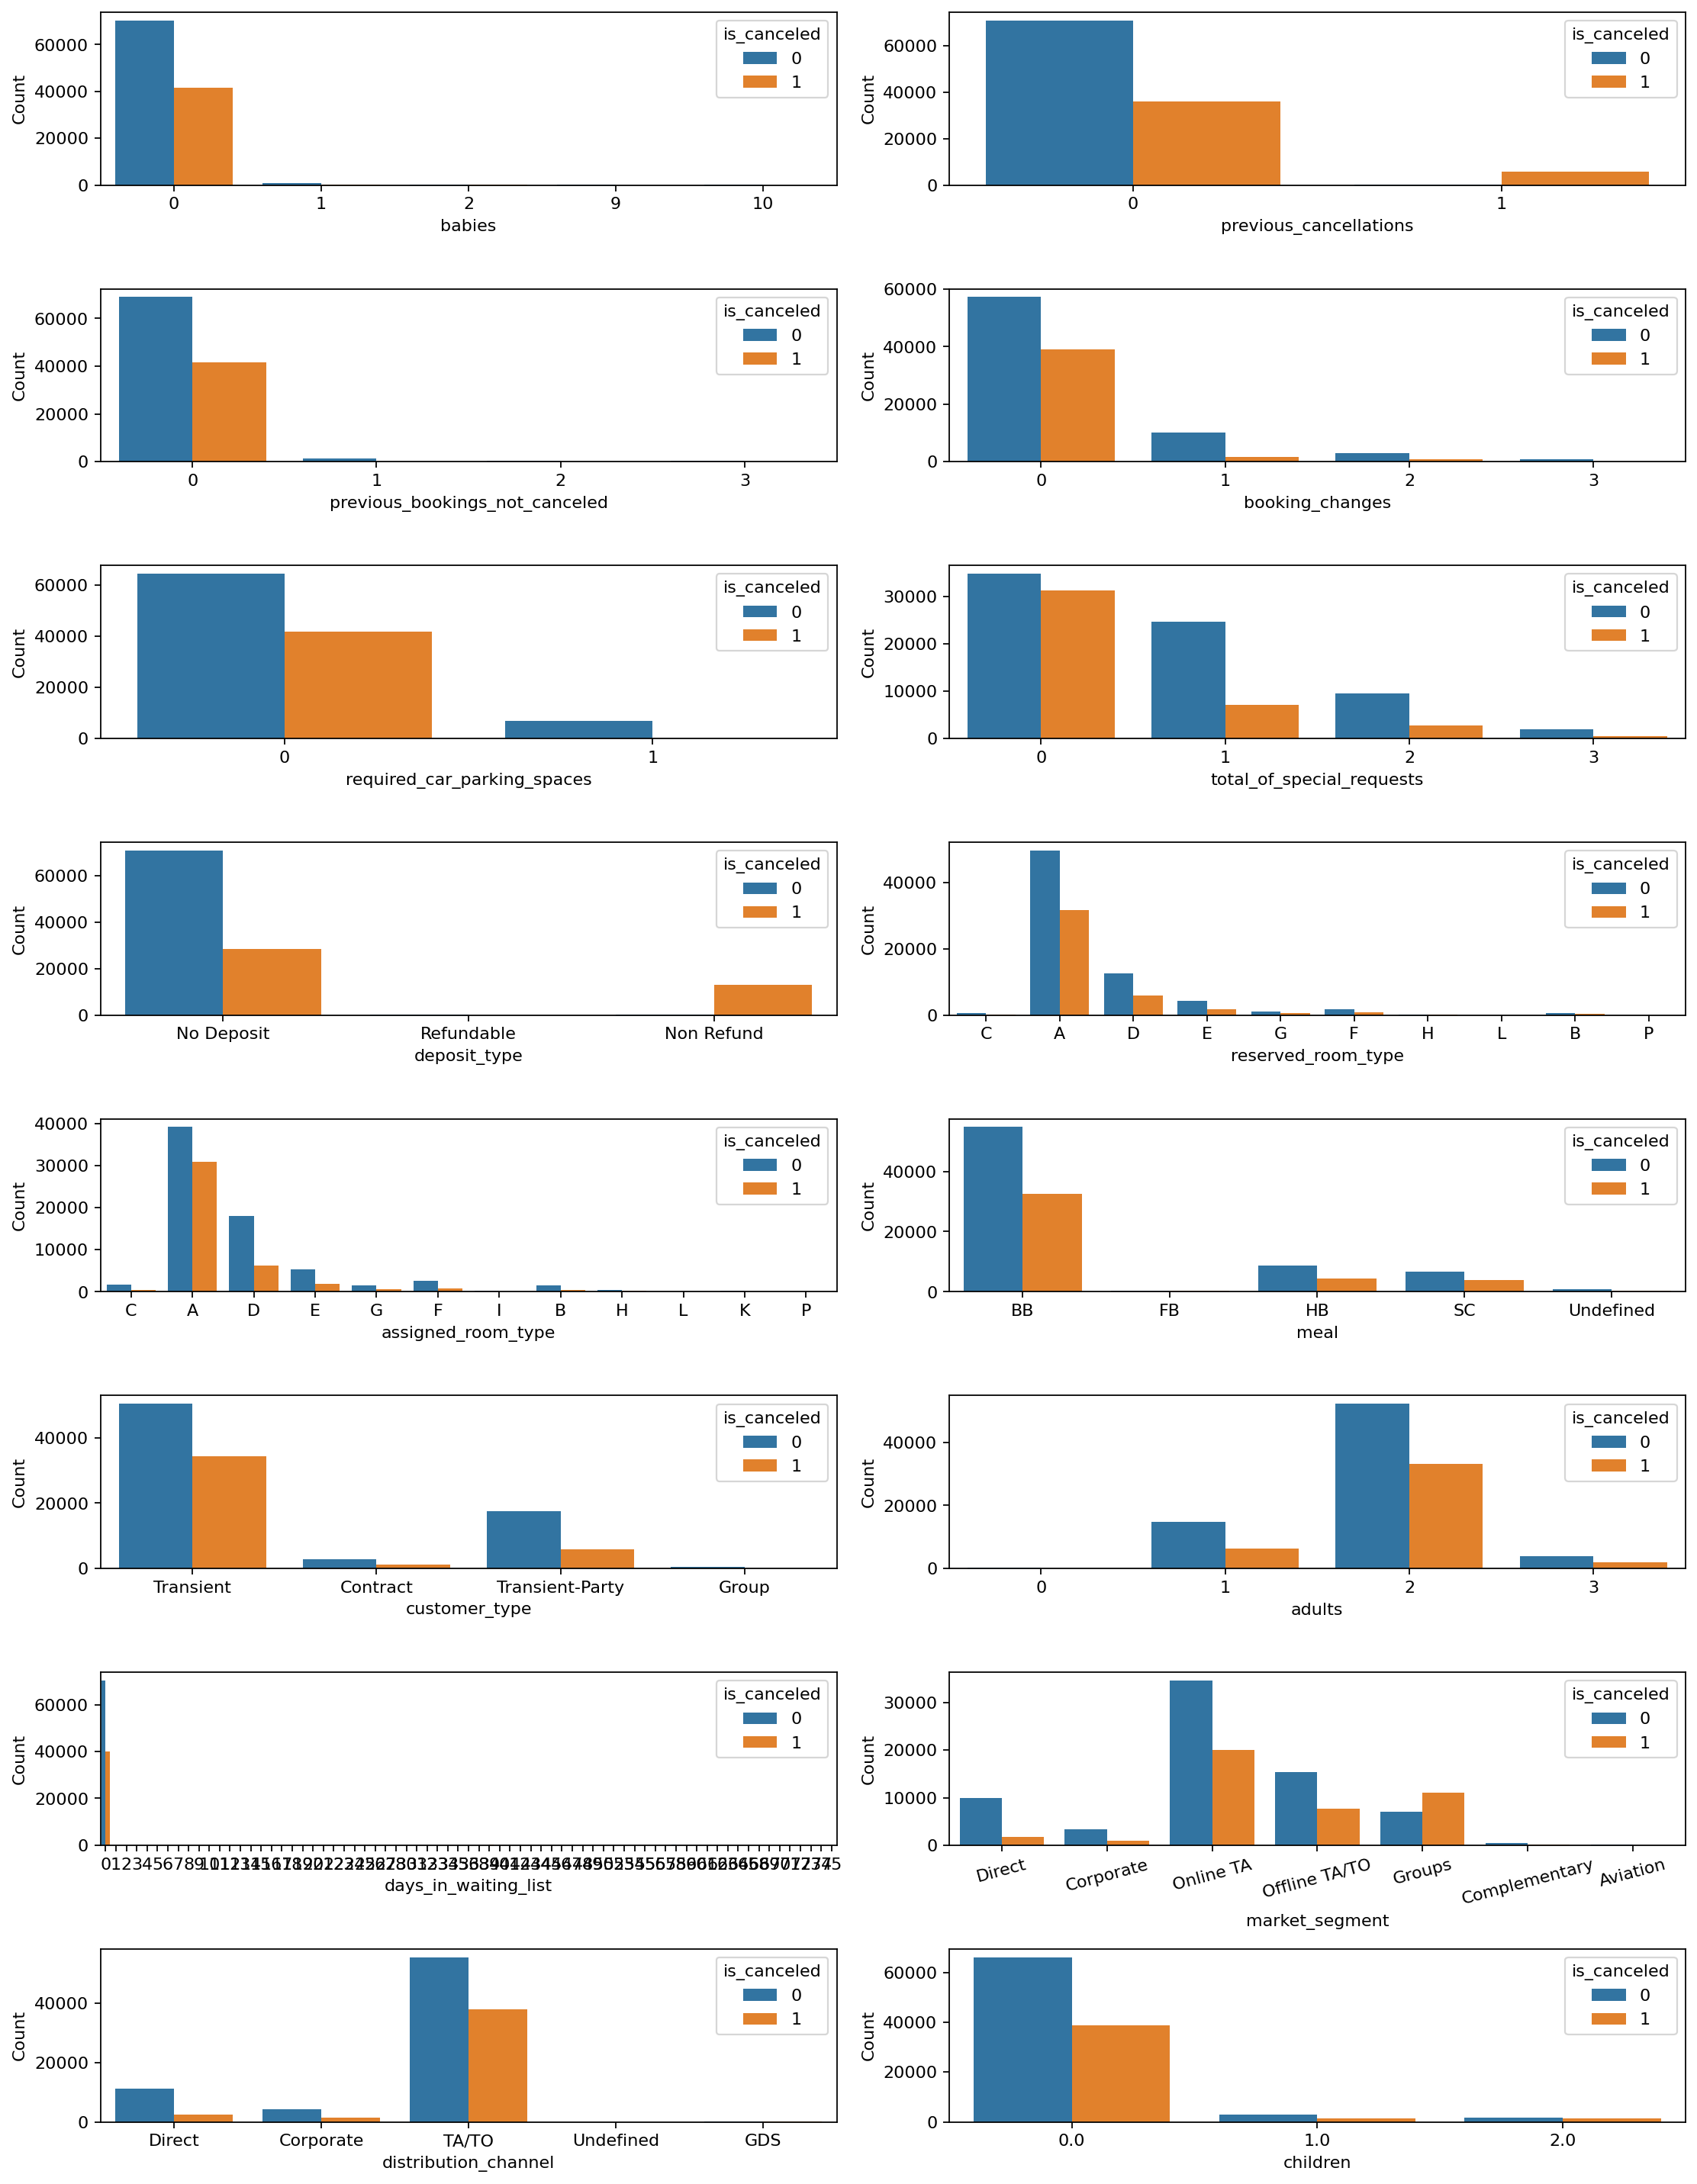

In [15]:
#Plot categorical/discrete variables as grouped by is_canceled
fig, axes = plt.subplots(8, 2, figsize=(14, 18))

axes = axes.flatten()
cols = ['children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'deposit_type', 'reserved_room_type', 'assigned_room_type', "meal", "customer_type", "adults", "days_in_waiting_list", "market_segment", "distribution_channel"]
for i, col in enumerate(cols):
    g = sns.countplot(x=col, hue='is_canceled', data=d, ax=axes[i-1])
    g.set_xlabel(col)
    g.set_ylabel('Count')
    if col == 'days_in_waiting_list':
        # Attempt to fix the x-axis
        xticks = np.concatenate(([0], np.arange(10, 76), 10), 76)
        axes[i].set_xticks(xticks)
        axes[i].set_xticklabels(xticks, rotation=45)
    if col == 'market_segment':
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(20))
        g.set_xticklabels(g.get_xticklabels(), rotation=15)
    sns.move_legend(g, "upper right")
fig.tight_layout()

print_pct = ['children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', "adults", "days_in_waiting_list"]

for col in print_pct:
    print("Percentage of entries for variable '", col, "' above 1: ",
         np.round(100*(d[d[col]>1].shape[0])/(d.shape[0]), 2))

print("Percentage of entries for variable 'total_of_special_requests' above 2: ",
         np.round(100*(d[d['total_of_special_requests']>2].shape[0])/(d.shape[0]), 2))

We note that in the columns <span style='font-family:Courier'>"babies", "children", "required\_car\_parking\_spaces", "days\_in\_waiting\_list", "previous\_cancellations", "previous\_bookings\_not\_cancelled", "booking\_changes", "required\_car\_parking\_spaces", and  "days\_in\_waiting\_list"</span> a large majority of entries take on the value zero. Furthermore the vast majority \(&gt;96%\) take on the value 0 or 1 \(see list above tables\). We have chosen therefore to change these columns to indicate whether the original value was zero or positive. For column '<span style='font-family:Courier'>total\_of\_special\_requests</span>', we note that only 2% exceed 2. We therefore encode this variable into two dummy variables indicating whether a booking made one special request or two or more special request. This was done following the investigation of entry congruency in the "<span style='font-family:Courier'>assigned\_room\_type</span>" and "<span style='font-family:Courier'>reserved\_room\_type</span>" columns directly below.


Create a contingency table  

```
table = pd.crosstab(d['reserved_room_type'], d['assigned_room_type'], values=d['is_canceled'], aggfunc='mean', normalize='index')
```

Create a Heatmap:

```
sns.heatmap(table, cmap='Blues', annot=True, fmt='.1%', cbar=False)
```

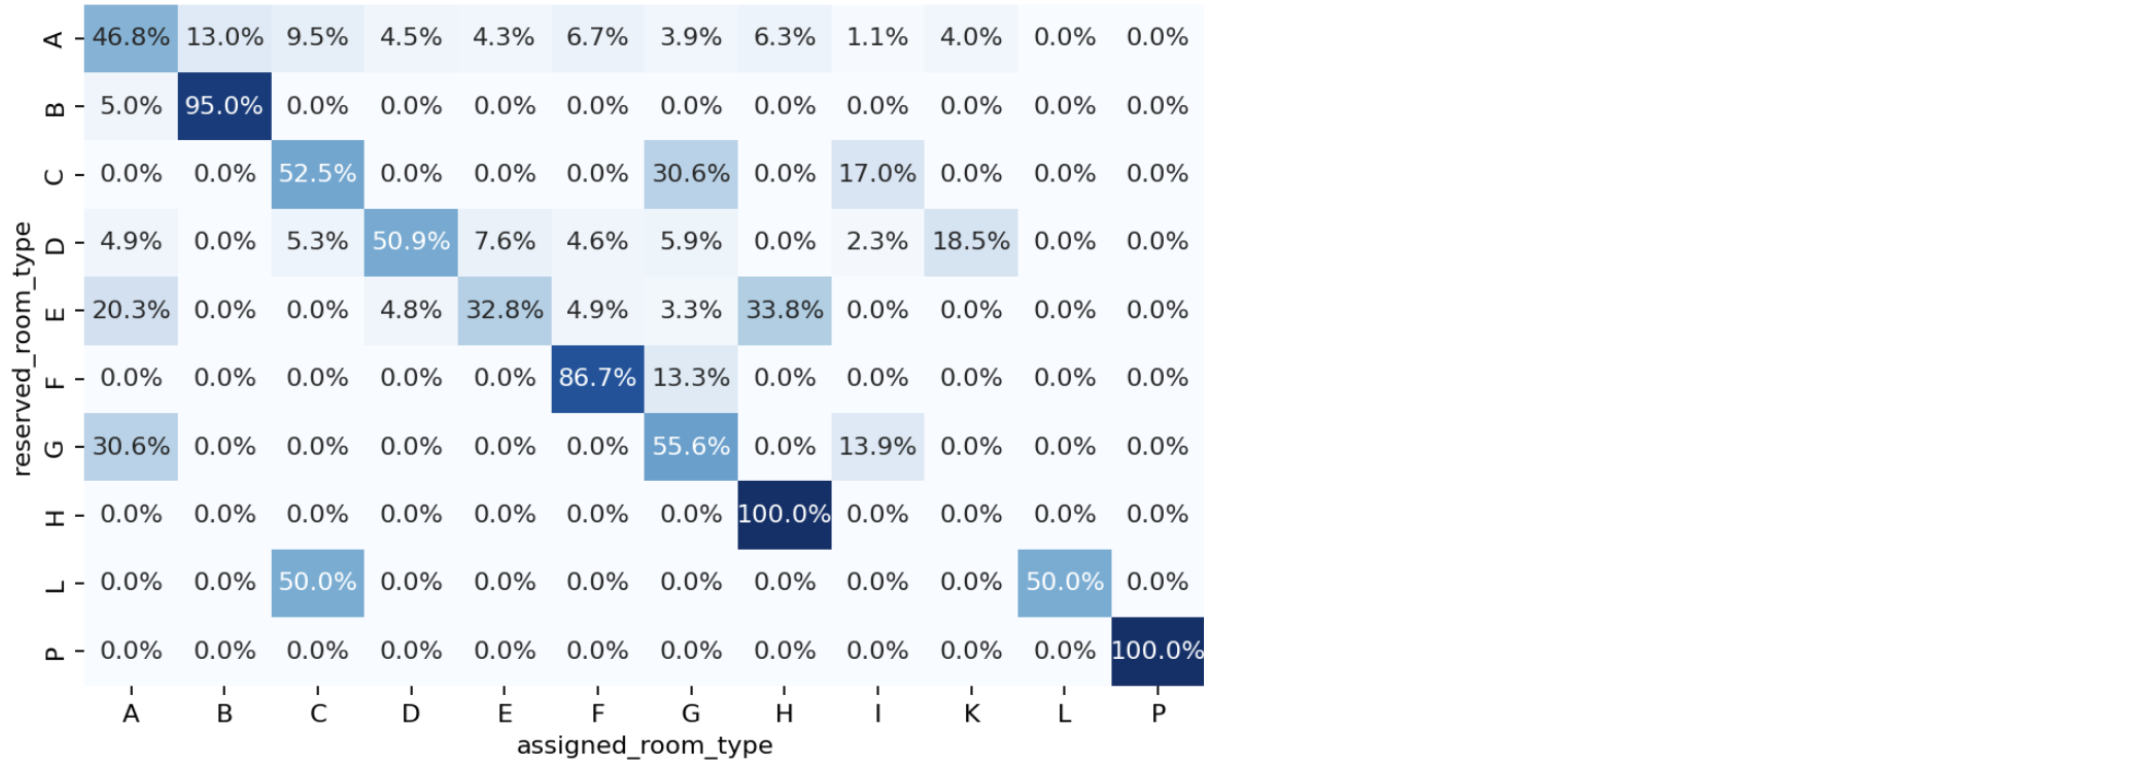

The congruency table above shows a relationship between the reserved room type and assigned room type, and how this affects cancellation. For example, if a booking had a "<span style='font-family:Courier'>reserved\_room\_type</span>" of E, but got <span style='font-family:Courier'>assigned\_room\_type</span> A, the ratio of cancellations for a "<span style='font-family:Courier'>reserved\_room\_type</span>" of E is 22.2%.
Given that the rows are the initially reserved room type and the columns are the assigned ones, we can see that the diagonal across \( for <span style='font-family:Courier'>reserved\_room\_type </span>=<span style='font-family:Courier'> assigned\_room\_type</span>\) is most prominent in the heat map. Therefore, it appears that when a guest was assigned the same room type as the one they booked, cancellation ratios were higher than when this was not the case. Since additionally some room types were only reserved or assigned very rarely, we decided to encode "<span style='font-family:Courier'>reserved\_room\_type</span>" and "<span style='font-family:Courier'>assigned\_room\_type</span>" in a single binary variable indicating whether the two were equal for a given entry \(1 when equal, 0 when not\).


Below, we effectuate the aforementioned changes and also make dummy variables for the remaining categorical variables <span style='font-family:Courier'>"customer\_type", "meal, " "hotel", "deposit\_type", "market\_segment", "distribution\_channel", and "total\_of\_special\_requests"</span> as discussed above. We also encode the variable "<span style='font-family:Courier'>arrival\_date\_month</span>" into a dummy variable indicating whether the booking was made for a stay in summer \(<span style='font-family:Courier'>"April", "May", "June", "July", "August", "September"</span>\) or winter \(the other months\).


In [16]:
columns_to_dummy = ["hotel", "meal", "market_segment", "distribution_channel", "deposit_type", "customer_type", "total_of_special_requests"]
d = pd.get_dummies(d, columns=columns_to_dummy, drop_first=True)
d["room_same"] = np.where(d["reserved_room_type"] == d["assigned_room_type"], 1, 0)

# create new column "arrival_date_summer"
d['arrival_date_summer'] = d['arrival_date_month'].isin(['April', 'May', 'June', 'July', 'August', 'September']).astype(int)

## Feature engineering Boolean categories
d=d.assign(Had_children="",Had_babies="",Cancelled_previously="",Not_cancelled_previous_bookings="",Booking_changes_made="",Requiring_car_park="")

#Fill in new variables, converting counts to binary status
def convert_to_binary_status(dataframe, col_name, new_col_name):
    dataframe[new_col_name] = (dataframe[col_name] > 0).astype(int)


convert_to_binary_status(d, 'children', 'Had_children')
convert_to_binary_status(d, 'babies', 'Had_babies')
convert_to_binary_status(d, 'previous_cancellations', 'Cancelled_previously')
convert_to_binary_status(d, 'previous_bookings_not_canceled', 'Not_cancelled_previous_bookings')
convert_to_binary_status(d, 'booking_changes', 'Booking_changes_made')
convert_to_binary_status(d, 'required_car_parking_spaces', 'Requiring_car_park')

## Drop the redundant variables
d = d.drop(columns = ['children', 'babies', 'previous_cancellations',
 'previous_bookings_not_canceled', 'booking_changes', "assigned_room_type", "reserved_room_type",
 'required_car_parking_spaces', "arrival_date_month"])
print(f"Dropped children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'assigned_room_type','reserved_room_type, 'required_car_parking_spaces', 'arrival_date_month'")

Dropped children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'assigned_room_type','reserved_room_type, 'required_car_parking_spaces', 'arrival_date_month'


To simplify features that contain both date and time, such as "arrival_date_week", and make them more interpretable, we have opted to transform "arrival_date_week" into a  variable which is increasing year-on-year. Previously, the data had weeks labeled from 1 to 53, which posed difficulties for interpretation as it looped back on itself. Therefore, we encoded the weeks using the "arrival_date_year" variable.

In [17]:
d_15 = d[d["arrival_date_year"]==2015]
print("Nr of weeks in 2015 :", np.max(d_15["arrival_date_week_number"]))

d_16 = d[d["arrival_date_year"]==2016]
print("Nr of weeks in 2016 :", np.max(d_16["arrival_date_week_number"]))

d_17 = d[d["arrival_date_year"]==2017]
print("Nr of weeks in 2017 :", np.max(d_17["arrival_date_week_number"]))

# Define a function to add 52 weeks based on year
def add_weeks(row):
    if row['arrival_date_year'] == 2015:
        return row['arrival_date_week_number'] 
    elif row['arrival_date_year'] == 2016:
        return row['arrival_date_week_number'] + 53
    elif row['arrival_date_year'] == 2017:
        return row['arrival_date_week_number'] + 106
    else:
        return row['arrival_date_week_number']

# Apply the function to the dataframe
d['week_number_adjusted'] = d.apply(add_weeks, axis=1)


# Drop the unecessary columns
d = d.drop(['arrival_date_week_number'], axis = 1)

Nr of weeks in 2015 : 53
Nr of weeks in 2016 : 53
Nr of weeks in 2017 : 35


### Addressing the <span style='font-family:Courier'>country</span> feature



In the map shown below, we plot the number of guests coming from each region of the world.

```
guest_city = d[d['is_canceled'] == 0]['country'].value_counts().reset_index()
guest_city.columns = ['Country', 'No of guests']
basemap = folium.Map()
guests_map = px.choropleth(guest_city, locations = guest_city['Country'],color = guest_city['No of guests'], hover_name = guest_city['Country'])
guests_map.show()
```
![alt text](./country_map.png)


Through EDA, we discovered that an overwhelming proportion of the bookings were attributed to the <span style='font-family:Courier'>country</span> Portugal \('PRT'\), with 39.73%  of the bookings (see cell below). Not only is this a sizeable percentage given that the dataset is shared with 174 other countries, but Portugal's cut is also 4 times larger than the next closest contributor, Great Britain \('GBR'\).

Attempts to encode the '<span style='font-family:Courier'>country</span>' variable resulted in a large number of features and a broad, sparse region of the dataset being created, so we considered encoding <span style='font-family:Courier'>country </span>into the top 14 countries by frequency of appearance whilst combining the rest into an '<span style='font-family:Courier'>other</span>' feature. However, we found through consultation of the literature that the higher prevalence of 'PRT' in the dataset could be attributed to fact that the hotels' booking protocols are designed to allocate a new booking's <span style='font-family:Courier'>country</span> information to PRT **in the event that no country is specified,** meaning that the <span style='font-family:Courier'>country </span>feature is inaccurate data \(Antonio, de Almeida and Nunes, Dec 2017\).

There is a potential for data leakage if guests provide their ID only at check\-in and hotels are able to pass this information to us. This is because it would only be possible for guests who actually arrive and do not cancel their reservation to provide their ID, which could create bias in our dataset. Since this directly impacts our classification problem of canceled reservations, we need to remove this variable from our analysis.

As stated in the discussion, we recommend the creation of a  'Undisclosed country of origin' category that the hotel booking protocol defaults to in the event of no country being specified. However, such a category did not exist in the dataset, and we could not distinguish invalid country entries for "PRT" from legitimate ones. We therefore decided to remove the "country" column from the dataset, due to the high ratio of the "PRT"\-category.



In [18]:
#count of each country's appearance
cont_counts=d.country.copy() #filter to just the country feature
cont_counts_d = cont_counts.value_counts().rename_axis('country').reset_index(name='counts') #count how many times each country shows up, save to df

#Showing what % of observations PRT is
total_obs=sum(cont_counts_d.counts) #save total number of bookings
portugal_section=round(((int(cont_counts_d[cont_counts_d['country']=='PRT']['counts']))/total_obs)*100, 2)

#How many countries are there, how many bookings attributed to Portugal
print(f"There are {len(cont_counts_d)} countries in the dataset\nPortugal accounts for {portugal_section}% of all bookings")

#Drop country column
d = d.drop(["country"], axis=1)
print('Country variable dropped')

There are 175 countries in the dataset
Portugal accounts for 39.73% of all bookings
Country variable dropped


### Interference assessment using correlation matrix



```
#Correlation plot before k best selection

# Correlation matrix
plt.subplots(figsize=(25,25))
sns.heatmap(d.corr().round(2), cmap='GnBu', annot=True)
plt.show()
```

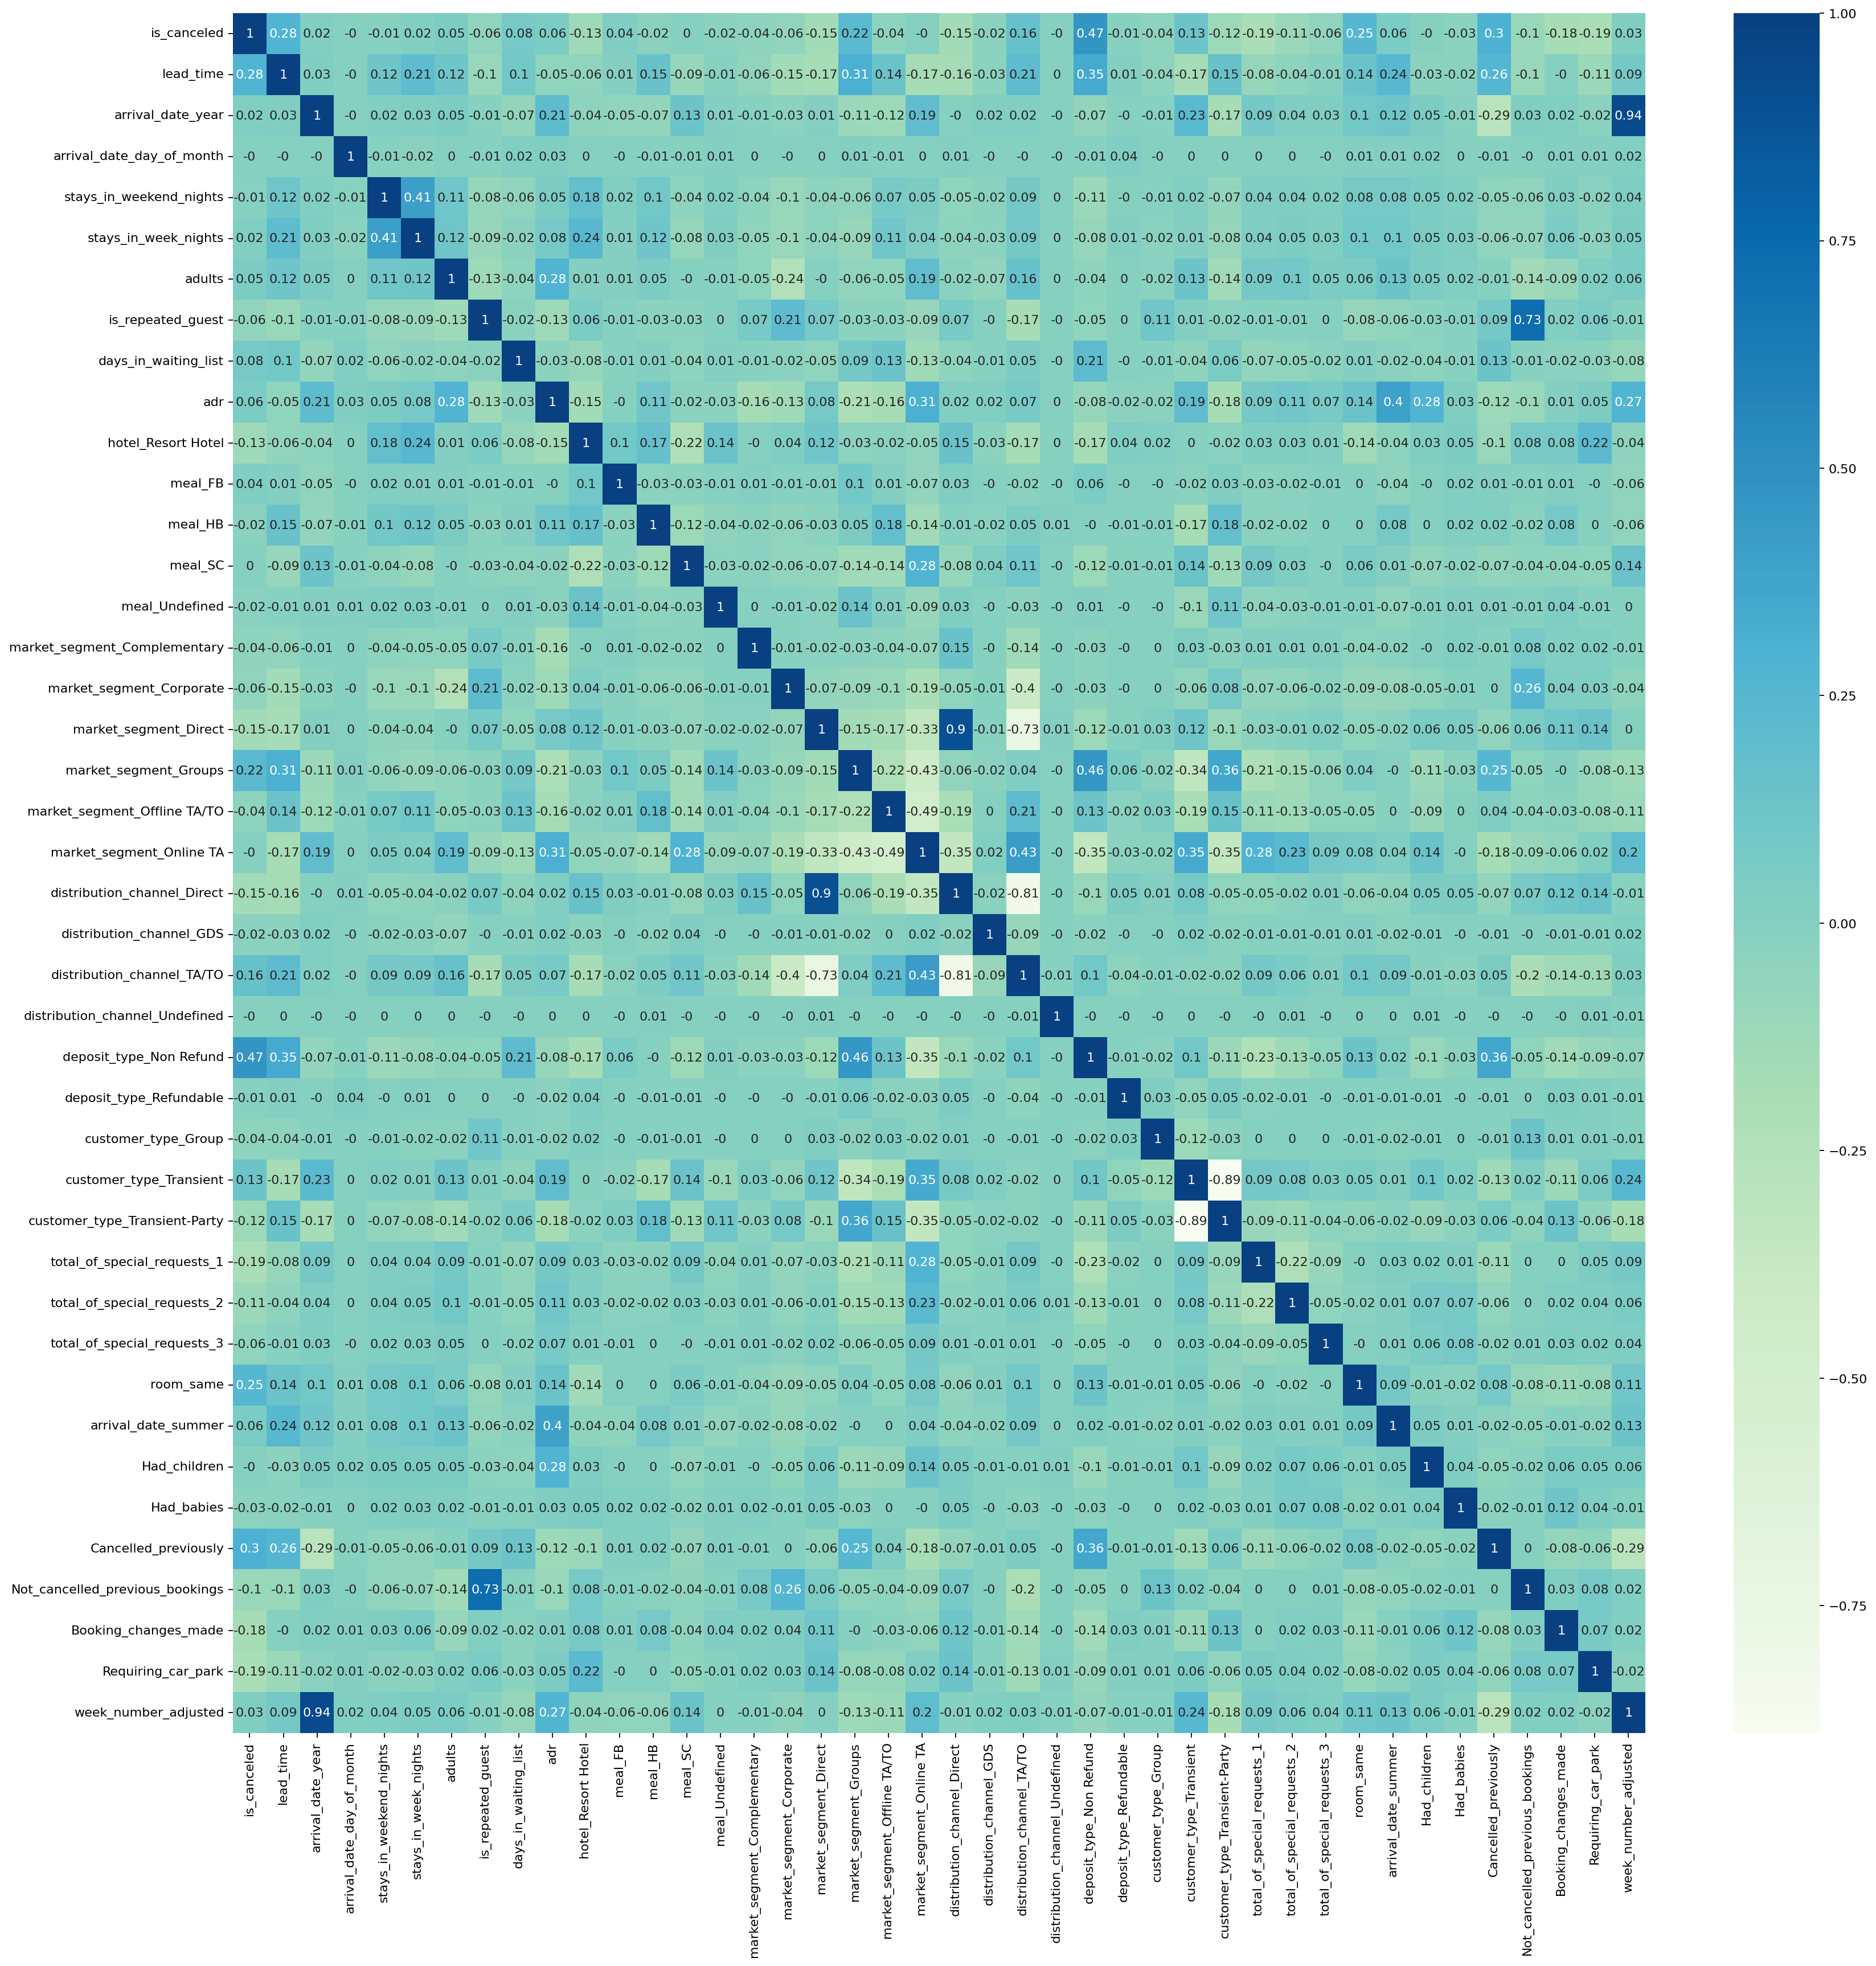



Before progressing further, we removed features showing a high correlation to others by computing a correlation matrix which measures the strength and direction of the linear relationship between pairs of variables. Using this analysis method, we identified that the features<span style='color:#ffc107'> </span><span style='font-family:Courier'>arrival\_date\_year, distribution\_channel\_Direct, Not\_cancelled\_previous\_bookings, customer\_type\_Transient\-Party</span> all showed a strong correlation \(correlation coefficients beyond $\pm0.7$ \)  with at least one other feature, warranting their removal from further analyses \(carried out in the cell below\). Though not shown later, the final selection of features used for model training had no correlation coefficients over $\pm0.4$ .

Features with a noticeable correlation render their correlates redundant and reduce the explainability of their coefficients in the predictive models they are used to generate, therefore it is preferential to drop such features.



In [19]:
d = d.drop(["arrival_date_year", "distribution_channel_Direct", "Not_cancelled_previous_bookings", "customer_type_Transient-Party"], axis=1)
print('Dropped "arrival_date_year", "distribution_channel_Direct", "Not_cancelled_previous_bookings", "customer_type_Transient-Party"')

Dropped "arrival_date_year", "distribution_channel_Direct", "Not_cancelled_previous_bookings", "customer_type_Transient-Party"


### Finding Best Features

We aim to find a model which is easily interpretable by the users (the hotels) and for which the number of parameters is limited, allowing the hotel to assess the likelihood of a booking being cancelled based on a restricted number of parameters. We choose features by running a 5-fold stratified cross-validation of random forests on the training data. The importance of each feature is calculated as the average, over each fold, of the mean decrease in Gini when a tree is split over that feature. We restrict the number of parameters to the 20 for which the average (mean) decrease in Gini is largest. When fitting our models, we used only the chosen features in order to quantify the degree to which each feature will increase (or decrease) the likelihood of a booking being canceled. Had we we fit the models on all features, it would have been impossible to assess the importance of the best features in isolation.



In [20]:
#split data
y = d['is_canceled']
X = d.drop(['is_canceled'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify=y, random_state=40)

#set up classsifier and stratified cv
sel = RandomForestClassifier(n_estimators = 400, bootstrap = True, max_features='sqrt', random_state = 40)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

feature_importances = []

#iterate over validation sets
for train_index, test_index in skf.split(X_train, y_train):
    X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    sel.fit(X_train_cv, y_train_cv)

    # get feature importances
    importances = sel.feature_importances_

    # create a list of (feature, importance) tuples
    fold_feature_importances = [(feature, importance) for feature, importance in zip(X_train.columns, importances)]

    feature_importances.append(fold_feature_importances)

# compute the average feature importance across all folds
avg_feature_importances = {}

for feature in X.columns:
    avg_importance = 0
    for fold in feature_importances:
        for f, imp in fold:
            if f == feature:
                avg_importance += imp
    avg_importance /= len(feature_importances)
    avg_feature_importances[feature] = avg_importance

# sort the list of feature importances by importance in descending order
sorted_feature_importances = sorted(avg_feature_importances.items(), key=lambda x: x[1], reverse=True)

# print the top 10 most important features
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {round(importance, 5)}")

lead_time: 0.15966
deposit_type_Non Refund: 0.13364
adr: 0.1116
week_number_adjusted: 0.0968
arrival_date_day_of_month: 0.08272
Cancelled_previously: 0.04937
stays_in_week_nights: 0.04701
room_same: 0.03565
total_of_special_requests_1: 0.03021
stays_in_weekend_nights: 0.02851
customer_type_Transient: 0.0269
Requiring_car_park: 0.02156
Booking_changes_made: 0.01925
total_of_special_requests_2: 0.01885
market_segment_Online TA: 0.01824
market_segment_Groups: 0.01788
adults: 0.0168
hotel_Resort Hotel: 0.01291
market_segment_Offline TA/TO: 0.01062
arrival_date_summer: 0.00977
distribution_channel_TA/TO: 0.0083
meal_HB: 0.00781
meal_SC: 0.00645
Had_children: 0.00623
total_of_special_requests_3: 0.00595
market_segment_Direct: 0.00558
days_in_waiting_list: 0.00241
is_repeated_guest: 0.00211
market_segment_Corporate: 0.00191
meal_FB: 0.00145
Had_babies: 0.00124
meal_Undefined: 0.00102
deposit_type_Refundable: 0.0005
market_segment_Complementary: 0.00042
customer_type_Group: 0.00039
distributio

The reader should be aware that in computing the most important features using the random forest, we have not restricted the depth of each decision tree being computed. This puts us at a risk, as random forests are prone to giving skewed importance to continuous and high\-cardinality features. However, as may be seen from the output above, 12 of the most important 20 features were binary, indicating that the random forest did not radically over\-select for continuous or high\-cardinality features.

In [21]:
#Making list of the k-best features (20) which have an importance over 0.1
k_best_feats=[]
for feature in sorted_feature_importances:
    if feature[1] > 0.009:
        k_best_feats.append(feature[0])

print(len(k_best_feats))

20


## Model Fitting and Tuning



Below, we show the processes carried out to fit our model on the given 
dataset. For the each model \(SVC, random forest classifier, decision tree classifier, and logistic regression\) we ran a stratified 5\-fold cross\-validation to determine the optimal hyperparameters. For logistic regression and SVC the only tuned hyperparameter was the penalty value $\lambda$ (an L2 penalty parameter was used). For the decision tree and random forest classifiers, tree depth, minimum entries per leaf, and minimum entries for a split were the tuned hyperparameters. For the SVC\-model, it was necessary to use only the first 4000 \(shuffled\) values from the training data in order to determine the optimal hyperparameter within feasible computation time. In line with the hotel desiring an accurate model, we opted to assess each model by means of its accuracy score \(true predictions over total predictions\). We found that the random forest and decision tree achieved accuracies of 0.816 and 0.78, respectively. \(Note that for both the tree and the forest, we restricted maximal tree depth to five during hyperparameter optimisation and fitting in order to reduce the complexity of any proposed model\). The SVC and Logistic regression achieved scores of 0.59 and 0.813, respectively. The optimal inverse penalty values on which the models were fittted were <span style='color:#f44336'>C=0.1</span> for the logisitic regression and 0.04 for the SVC. We recognise, however, that the poor score for the linear SVC model may be due to a poor inverse penalty parameter selected due to only including a subset of the training data for cross\-validation. While these values correspond to high penalties, we found that the logistic regression displayed almost identical results for inverse penalty values in the range \[1,10\]. Although the logistic regression was narrowly outperformed by the random forest, we prefer the logistic regression due to the ease with which the effect of its coefficients can be interpreted.


In [22]:
#Preparing the split data for use in model training
X_train = X_train[k_best_feats]
X_test = X_test[k_best_feats]

### Logistic Regression
Below, we show the code with which we determined the optimal hyperparameter $C = 1/\lambda$ for logistic regression. The subsequent cell shows the model being fit and its accuracy metrics output.

The goal of using Logistic Regression for hotel booking and cancellation is to identify the most important features that contribute to cancellations and to find ways to reduce the number of cancellations or predicting when and how often they will occur. By analyzing the coefficients of the logistic regression model, we can determine which features are more important and which have a greater impact on the cancellation rate.

In [23]:
scaler = StandardScaler()

# Fit the scaler to the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Create a Logistic Regression model and fit it to the training data
lr_cv = GridSearchCV(LogisticRegression(max_iter=10000),
              param_grid={'C': np.linspace(0,10,101)},
              scoring = ["accuracy", "f1", "recall", "precision", "balanced_accuracy"], cv=StratifiedKFold(n_splits=5),
                            refit="accuracy", return_train_score=True)

lr_cv.fit(X_train_scaled, y_train)

#print best parameters
clear_output(wait=True)
print(lr_cv.best_params_)

{'C': 0.1}


Accuracy: 0.81046
Precision: 0.81
Recall: 0.81
F1-score: 0.80
Confusion Matrix:
 [[16360  1398]
 [ 3938  6457]]


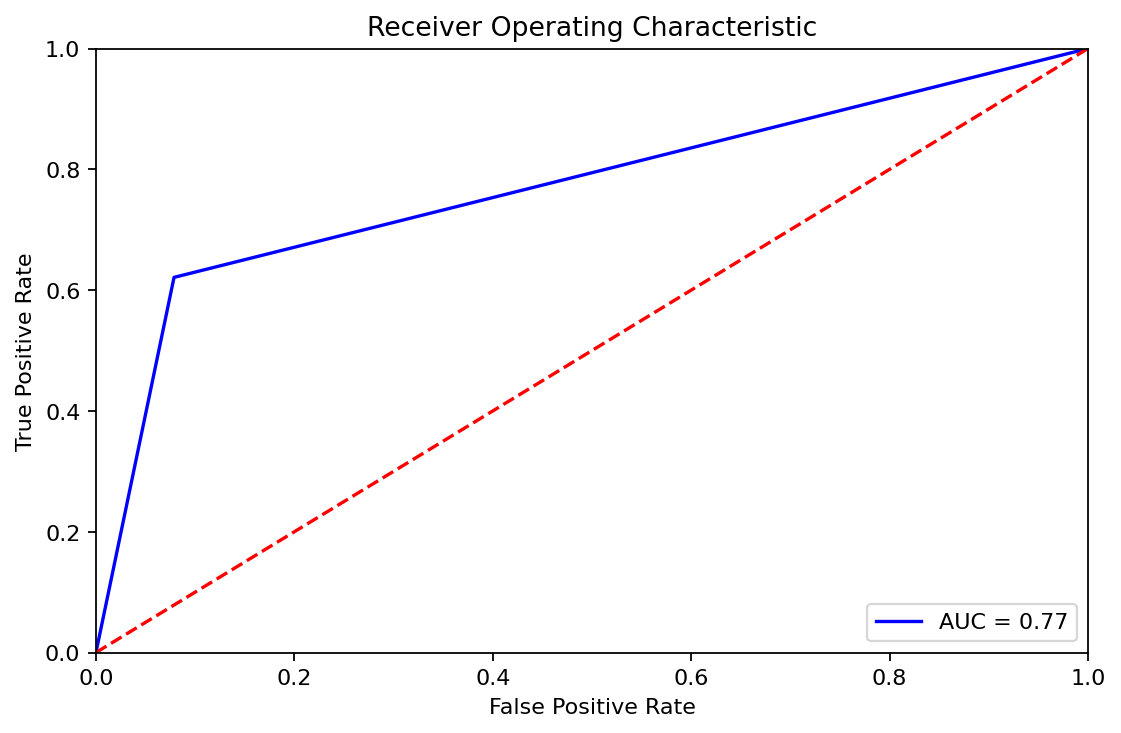

In [24]:
#Use the best paramters as shown above to test the model.
lr = LogisticRegression(C=0.1, max_iter=10000)
lr.fit(X_train_scaled, y_train)

# Use the trained model to make predictions on the test data
y_pred_lr = lr.predict(X_test_scaled)

# Compute accuracy, confusion matrix, and classification report for the Logistic Regression model
acc_lr = accuracy_score(y_test, y_pred_lr)
conf = confusion_matrix(y_test, y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)
tn, fp, fn, tp = conf.ravel()

#Prints the metrics
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_lr)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred_lr, average='weighted')))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred_lr, average='weighted')))
print("F1-score: {:.2f}".format(f1_score(y_test, y_pred_lr, average='weighted')))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


# Evaluated and analyze the coefficients of the Logistic Regression model
coef = pd.DataFrame(lr.coef_, columns=X_train.columns)
coef = coef.T
coef.columns = ['Coefficient']
coef = coef.sort_values(by='Coefficient', ascending=False)

#Adding an ROC curve
# ROC curve giving AUC score
fpr, tpr, threshold = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1]);plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

By analysing the coefficients of the logistic regression model, we can determine which features are more important in predicting cancellations. For example, we see that <span style='font-family:Courier'>deposit\_type\_Non\_Refund</span> and <span style='font-family:Courier'>Cancelled\_previously </span>have the highest positive coefficients, this indicates that bookings with non-refundable deposits  and customers who have previously cancelled are more likely to result in cancellations . The coefficients displayed alongside their corresponding features indicate the increase in log\-odds of a cancellation occurring over a non\-cancellation when the value of the corresponding variable increases by 1 standard deviation \(since we used standard scaling\). In essence, a positive coefficient indicates a feature which increases the chance of a booking being cancelled and vice\-versa for a negative coefficient. Below, we have identified the 8 most important features.

In [25]:
# Get the coefficients and their corresponding feature names
coef = lr.coef_[0]
feature_names = X_train.columns.tolist()

# Create a dictionary of feature names and their corresponding coefficients
coef_dict = {}
for i in range(len(feature_names)):
    coef_dict[feature_names[i]] = coef[i]


# Sort the dictionary by coefficient magnitude (absolute value)
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True))

# Print the top 8 coefficients with their corresponding feature names
for i, (feat, coeff) in enumerate(sorted_coef_dict.items()):
    if i >= 8: # Change this to display more or fewer coefficients
        break
    print(f"{i+1}. {feat}: {coeff:.2f}")

1. deposit_type_Non Refund: 1.69
2. Requiring_car_park: -1.51
3. Cancelled_previously: 0.96
4. room_same: 0.59
5. market_segment_Online TA: 0.57
6. total_of_special_requests_1: -0.47
7. total_of_special_requests_2: -0.37
8. lead_time: 0.37


## Discussion & Conclusions



### <u>Our findings</u>

Our final and preferred model was the logistic regression. This model was cross validated over 101 penalty values in the range $[0, 10]$, resulting in a recommended parameter of C=0.1. Through assessment of the confusion matrix and ROC curve (abive), we identified that the model was quite reliable \(AUC\-ROC=0.77\) and had a good overall performance with an accuracy of 81.1%.

For transparency, the model is not perfect. We note that, despite its satisfactory accuracy, the recall was 0.81. Relying on a model with a poor recall rate may result in predicting cancellations incorrectly, resulting in a booking being unexpectedly honoured by guests and the hotel being overbooked. This is undesirable as hotels are typically responsible for arranging accommodation for their excess guests and the financial burden of this responsibility is unpredictable. Furthermore, our model did result in some false negative results. A model which incorrectly predicts a non\-cancellation could leave the hotel with unexpected cancellations which would reduce the hotel's financial gain as a business. This is equally undesirable compared to overbooking and should be considered when using this model as part of the hotels' larger business model. 

In extension to our work here, previous literature such as \(Chen et al., 2023\) has shown that using a Bayesian networks based on finite predictors alongside a linear Lasso model would provide a good cancellation prediction for hotel booking cancellations, however this was beyond the scope of our report as they used several other large datasets which would be incompatible here due to the computational limitations mentioned.

<u>**Interpretation**</u>

Our final model produced some insights into the most important factors for booking cancellation and non\-cancellation. These are indicated below and readers should note that our additional metric of K best feature selection corroborated each of these findings with an importance of at least 1%, meaning there was some discernible impact on cancellation rate. According to our findings, we have made recommendations as to actions a hotel can make in order to reduce cancellation rates. We should note, however, that any such action could itself impact cancellation rates positively or negatively in its own right. We therefore emphasise that the model should also be used by hoteliers as a predictive instrument to gauge the likelihood of cancellations for existing bookings. This will allow the hotel to prepare accordingly, for example by appropriate changes to operations to operations if many cancellations are predicted. The factors are listed in descending order of contribution to the likelihood or a booking being cancelled or not cancelled (in terms of the coefficients from the logistic regression on the standardised data).

|       <u>Factors which increased cancellation rate</u> | <u>Suggestion for hoteliers to improve cancellation rate</u> |
| :----------------------------------------------------------: | :---------------------------------------------------------------------------------------------------------------------------------------------------- |
|                Booking had no refund available | Reduce the opportunity for stays to be paid in full at the time of booking \(discussed below\) |
|  A booking was made by someone who had previously cancelled | Tailor offerings to these guests, incentivising not cancelling a booking. Alternatively,  be wary of what booking is being offered to these customers |
| The assigned room was the same type as that which was booked | Offer room changes where possible. In the real world, we assume a desirable change would be an upgrade in room standard/ amenities. |
|        The booking was made by an online Travel Agent | It's recommended to avoid using this channel for making bookings and instead encourage the use of channels such as direct booking. |
|               A longer lead time before booking | Control the booking window \(discussed below\) |
|  |  |
|      <u>**Factors which reduced cancellation rate**</u> | <u>**Suggestion for hoteliers to improve cancellation rate**</u> |
|                  A booking requires car park | Offer car parking spaces as an incentive to guests |
|             A booking included 1 special request | Fulfil special requests where possible and keep a record on the booking entry |
|        A booking included at least 2 special requests | As above, though accommodating more than 1 request does not predict a non\-cancellation as strongly |

<u>**Further recommendations**</u>

The <span style='font-family:Courier'>deposit\_type\_Non\_Refund</span> feature is defined as 'a deposit was made in the value of the total stay'. It is difficult to discern a causal link between a non\-refundable booking and the predicted increased likelihood of the booking being cancelled, though we hypothesise that stays which are paid in full could be of lower value and therefore not as much of a cost to the cancelling guest. Ultimately, we recommend promoting a booking with a partial deposit instead of taking payment in full at the outset.

Our model suggest that, the longer the lead time of a booking, the higher the chance of a cancellation. Our recommendation following this is to restrict how far in advance a booking can be made before the stay takes place, therefore reducing the time for a potential cancellation to occur. 

As previously stated, the hotel booking protocol should be amended in future data collection to identify where the booker's country of origin is not specified. This would improve data accuracy, enabling future repeats of this analysis to distinguish the predictive power of not disclosing the origin country on potential cancellations and similarly would put the country of origin 'Portugal' in context with the other countries in the analysis. The hotels should similarly ensure that there is as little blank space in the data as possible, as missing data has ambiguous meaning \(i.e. does this lack of data represent a 0 value or is this a clerical error?\). 

We recommend consulting domain experts or data authors during the data cleaning stages of repeat analyses, who might be able to shed light on the intricacies of the data or trends in the data which are affected by real\-world forces in the industry \(such as the possibility of bookings being logged multiple times or fraudulent bookings which should not be allowed to increase the count of cancellations\). The booking protocol could additionally be improved by including an anonymised booking reference code, whereby bookings made in conjunction share a code determining the fact the bookings are individually discrete but could be identical in their features. This would aid in downstream differentiation of true duplicates in the data which should be removed \(versus bookings which were purposefully identical but discrete entries\).

<u>**Economic viability**</u>

We determine that our model would not be sustainable for the long term, owing to the fact that it leads to overbooking rather than underbooking. We do restate, however, that consultation of domain experts may indicate which of these outcomes would be preferrable. If a model preferring underbooking is preferrable, then an alternative model should be sought.

There is a balance to be struck in any tampering of the controllable factors stated in this discussion: on the one hand, the hotel should make efforts to decrease booking cancellations by following our recommendations where financially feasible \(thus increasing their financial gain and custom\), on the other hand, restricting booking customers too much and removing choice \(as in lead time restriction, online travel agent avoidance, controlling refund options\) may reduce the hotels' reputation and drive custom away, therefore causing loses. We trust that hoteliers using this report will therefore make informed decisions based on our recommendations.



## References



Antonio, N., de Almeida, A. and Nunes, L. \(Dec 2017\) Predicting Hotel Bookings Cancellation with a Machine Learning Classification Model. IEEE, pp. 1049.  


Chen, S., Ngai, E.W.T., Ku, Y., Xu, Z., Gou, X. and Zhang, C. \(2023\) 'Prediction of hotel booking cancellations: Integration of machine learning and probability model based on interpretable feature interaction', Decision Support Systems, . doi: 10.1016/j.dss.2023.113959.  

